In [1]:
%matplotlib inline
import numpy as np                                    #arrays and matrix math
import pandas as pd                                   #work with DataFrames
import matplotlib.pyplot as plt                       #plotting and visualization
import matplotlib.dates as mdates                     #datetime formate in plots

import h5py                                           #import h5 files
import os                                             #OS operations
import scipy.signal as signal                         #signal processing
from scipy.io import loadmat                          #load MatLab m-files

from time import time                                 #timer for training

from skimage.metrics import mean_squared_error as image_mse         #Mean Squared Error
from skimage.metrics import structural_similarity as image_ssim     #Structural Similarity Index
from skimage.metrics import peak_signal_noise_ratio as image_psnr   #Peak Signal-Noise Ratio

# Define arguments for text box in PLT.TEXT()
my_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Check tensorflow GPU settings
import tensorflow as tf
sys_info = tf.sysconfig.get_build_info()
print('Tensorflow built with CUDA?',  tf.test.is_built_with_cuda())
print('Devices available:', tf.config.experimental.list_physical_devices())
print('# GPU available:', len(tf.config.experimental.list_physical_devices('GPU')))
print("CUDA: {} | cuDNN: {}".format(sys_info["cuda_version"], sys_info["cudnn_version"]))
tf.config.list_physical_devices()

Tensorflow built with CUDA? True
Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

***

In [2]:
# EXPERIMENT 54 ONLY
data_exp54 = pd.read_pickle('data_exp54.pkl')
print('Experiment 54 shape: {}'.format(data_exp54.shape))

time_complete_exp54 = np.array([loadmat('time_complete_54.mat')['time']], dtype='datetime64[us]').reshape(-1)
print('Times for Experiment 54 shape: {}'.format(time_complete_exp54.shape))

trange_54 = mdates.date2num(time_complete_exp54)
xrange_54 = np.arange(4950, 5150)
print('Timerange 54: {}'.format(trange_54.shape))
print('X-range 54: {}'.format(xrange_54.shape))

Experiment 54 shape: (200, 4200000)
Times for Experiment 54 shape: (4200000,)
Timerange 54: (4200000,)
X-range 54: (200,)


In [3]:
# fig, ax1 = plt.subplots(1, 1, figsize=(20,10))
# date_format = mdates.DateFormatter('%H:%M:%S')

# im1 = ax1.imshow(data_exp54, aspect='auto', cmap='seismic', vmin=-50, vmax=50, extent=[trange_54[0], trange_54[-1], xrange_54[-1], xrange_54[0]])
# ax1.xaxis_date(); ax1.xaxis.set_major_formatter(date_format)
# ax1.set_xlabel('Time [s] on 06/20/2019'); ax1.set_ylabel('Distance [m]'); ax1.set_title('Experiment 54')
# plt.colorbar(im1, ax=ax1)

# fig.autofmt_xdate()
# plt.show();

***

Deep Learning AutoEncoders (DL-AE)

In [4]:
import keras
import visualkeras
from keras import Model, regularizers
from keras.layers import Input
from keras.layers import Flatten, Reshape, LeakyReLU, Lambda
from keras.layers import Dense, Conv1D, Conv1DTranspose
from keras.layers import MaxPooling1D, UpSampling1D, BatchNormalization

In [5]:
# Function to plot training process
def plot_loss(fit):
    epochs     = len(fit.history['loss'])
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'],     '-', label='loss')
    plt.plot(iterations, fit.history['val_loss'], '-', label='validation loss')
    plt.title('Training: MSE vs epochs'); plt.legend()
    plt.xlabel('Epochs'); plt.ylabel('MSE')
    plt.xticks(iterations[::epochs//10])

In [6]:
from scipy.signal import decimate
X_train = decimate(data_exp54, 5).T
print('X_train shape: {}'.format(X_train.shape))

X_train shape: (840000, 200)


In [7]:
latent_shape = 20

***

FCNN

Number of parameters: 102,820
Training Time: 3.52 minutes
26250/26250 [==============================] - 31s 1ms/step
MSE: 1.971e-02
SSIM: 0.45
PSNR: 23.07


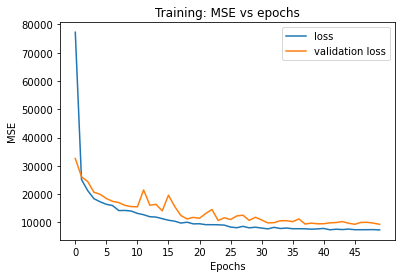

In [8]:
keras.backend.clear_session()

# Define architecture
inp = Input(shape=(200,))
x   = Dense(units=150, activation=LeakyReLU())(inp)
x   = Dense(units=100, activation=LeakyReLU())(x)
x   = Dense(units=50, activation=LeakyReLU())(x)
enc = Dense(units=latent_shape,  activation=LeakyReLU())(x)
x   = Dense(units=50, activation=LeakyReLU())(enc)
x   = Dense(units=100, activation=LeakyReLU())(x)
x   = Dense(units=150, activation=LeakyReLU())(x)
dec = Dense(units=200)(x)

# Define models
fcnn_encoder = Model(inp, enc)
fcnn_model   = Model(inp, dec)
print('Number of parameters: {:,}'.format(fcnn_model.count_params()))

# Compile & Fit
fcnn_model.compile(optimizer = 'adam',
                   loss      = 'mse',
                   metrics   = ['mse'])
start = time()
fit = fcnn_model.fit(X_train, X_train,
                    shuffle          = False,
                    epochs           = 50,
                    batch_size       = 500,
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
fcnn_model.save('fcnn.h5')
print('Training Time: {:.2f} minutes'.format(train_time/60))

fcnn_pred = fcnn_model.predict(X_train).astype('float64')

data_norm = X_train / np.max(np.abs(X_train), axis=0)
pred_norm = fcnn_pred / np.max(np.abs(fcnn_pred), axis=0)
print('MSE: {:.3e}'.format(image_mse(data_norm, pred_norm)))
print('SSIM: {:.2f}'.format(image_ssim(data_norm, pred_norm)))
print('PSNR: {:.2f}'.format(image_psnr(data_norm, pred_norm)))

plot_loss(fit)

26250/26250 [==============================] - 20s 746us/step
Latent Space dimensions: (840000, 20)


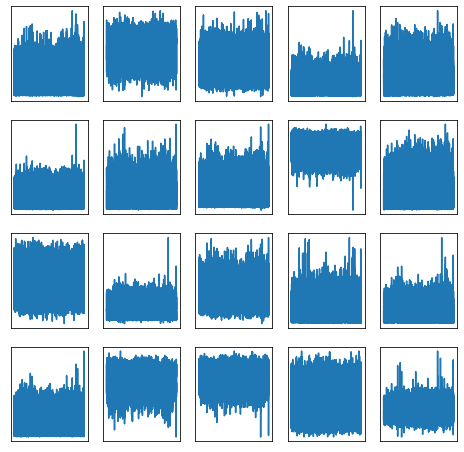

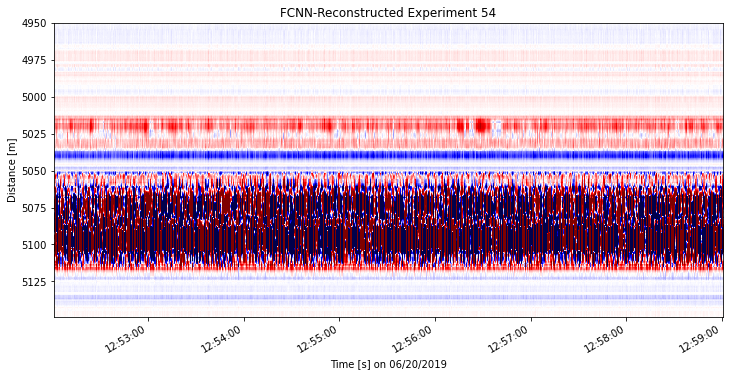

In [9]:
fcnn_latent = fcnn_encoder.predict(X_train) 
print('Latent Space dimensions: {}'.format(fcnn_latent.shape))
plt.figure(figsize=(8,8), facecolor='white')
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fcnn_latent[:,i])
    plt.xticks([]); plt.yticks([])
plt.show();

fig, ax1  = plt.subplots(1, 1, figsize=(12,6))
date_format = mdates.DateFormatter('%H:%M:%S')
im1 = ax1.imshow(fcnn_pred.T, aspect='auto', cmap='seismic', vmin=-50, vmax=50, extent=[trange_54[0], trange_54[-1], xrange_54[-1], xrange_54[0]])
ax1.xaxis_date(); ax1.xaxis.set_major_formatter(date_format)
ax1.set_xlabel('Time [s] on 06/20/2019'); ax1.set_ylabel('Distance [m]') 
ax1.set_title('FCNN-Reconstructed Experiment 54')
fig.autofmt_xdate()
plt.show();

***

CNN

Number of parameters: 171,677
Training Time: 12.89 minutes
26250/26250 [==============================] - 73s 3ms/step
MSE: 1.527e-02
SSIM: 0.50
PSNR: 24.18


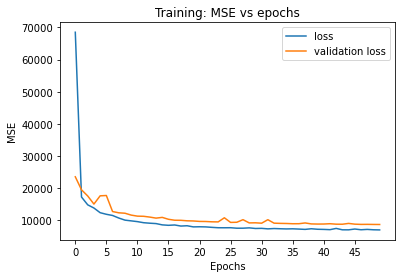

In [10]:
keras.backend.clear_session()

# Define architecture
inp = Input(shape=(200,1))
x   = Conv1D(4, 3, padding='same', activation=LeakyReLU())(inp)
x   = MaxPooling1D(2)(x)
x   = Conv1D(16, 3, padding='same', activation=LeakyReLU())(x)
x   = MaxPooling1D(2)(x)
x   = Conv1D(32, 3, padding='same', activation=LeakyReLU())(x)
x   = MaxPooling1D(2)(x)
shape_before_flatten = keras.backend.int_shape(x)[1:]
x   = Flatten(name='latent_dim')(x)
x   = Dense(100, activation=LeakyReLU())(x)
enc = Dense(latent_shape)(x)
x   = Dense(100, activation=LeakyReLU())(enc)
x   = Dense(np.prod(shape_before_flatten))(x)
x   = Reshape(shape_before_flatten)(x)
x   = Conv1D(32, 3, padding='same', activation=LeakyReLU())(x)
x   = UpSampling1D(2)(x)
x   = Conv1D(16, 3, padding='same', activation=LeakyReLU())(x)
x   = UpSampling1D(2)(x)
x   = Conv1D(4, 3, padding='same', activation=LeakyReLU())(x)
x   = UpSampling1D(2)(x)
dec = Conv1D(1, 3, padding='same')(x)

# Define models
cnn_encoder = Model(inp, enc)
cnn_model   = Model(inp, dec)
print('Number of parameters: {:,}'.format(cnn_model.count_params()))

# Compile & Fit
cnn_model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mse'])
start = time()
fit = cnn_model.fit(X_train, X_train,
                    shuffle          = False,
                    epochs           = 50,
                    batch_size       = 500,
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
cnn_model.save('cnn.h5')
print('Training Time: {:.2f} minutes'.format(train_time/60))
plot_loss(fit)

cnn_pred = cnn_model.predict(X_train).astype('float64').squeeze()

data_norm = X_train / np.max(np.abs(X_train), axis=0)
pred_norm = cnn_pred / np.max(np.abs(cnn_pred), axis=0)
print('MSE: {:.3e}'.format(image_mse(data_norm, pred_norm)))
print('SSIM: {:.2f}'.format(image_ssim(data_norm, pred_norm)))
print('PSNR: {:.2f}'.format(image_psnr(data_norm, pred_norm)))

26250/26250 [==============================] - 31s 1ms/step
Latent Space dimensions: (840000, 20)


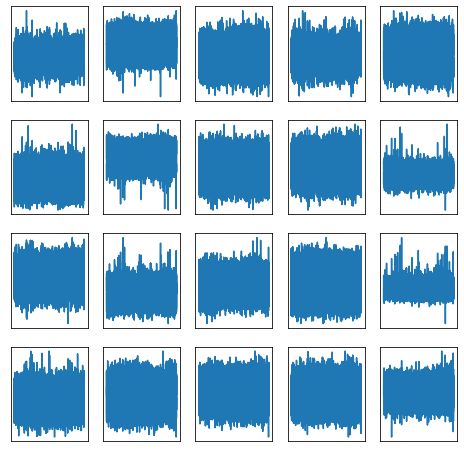

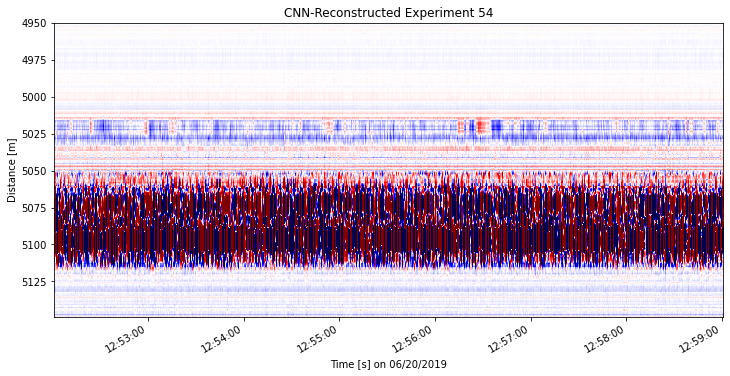

In [11]:
cnn_latent = cnn_encoder.predict(X_train) 
print('Latent Space dimensions: {}'.format(cnn_latent.shape))
plt.figure(figsize=(8,8), facecolor='white')
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(cnn_latent[:,i])
    plt.xticks([]); plt.yticks([])
plt.show();

fig, ax1  = plt.subplots(1, 1, figsize=(12,6))
date_format = mdates.DateFormatter('%H:%M:%S')
im1 = ax1.imshow(cnn_pred.T, aspect='auto', cmap='seismic', vmin=-50, vmax=50, extent=[trange_54[0], trange_54[-1], xrange_54[-1], xrange_54[0]])
ax1.xaxis_date(); ax1.xaxis.set_major_formatter(date_format)
ax1.set_xlabel('Time [s] on 06/20/2019'); ax1.set_ylabel('Distance [m]') 
ax1.set_title('CNN-Reconstructed Experiment 54')
fig.autofmt_xdate()
plt.show();

***

# END